In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [2]:
import pandas as pd
import scanpy as sc
import pandas as pd
import numpy as np

In [4]:
pdata

AnnData object with n_obs × n_vars = 902 × 199

In [5]:
dir = r'data\SPATIAL CITE SEQ\GSM6578065_humanskin_RNA.tsv'
gdata = sc.read_csv(r"C:\Users\KARAN\Desktop\GSE213264_RAW\GSE213264_RAW\GSM6578060_mouseintestine_RNA.tsv", delimiter='\t')

In [6]:
gdata

AnnData object with n_obs × n_vars = 902 × 20444

In [7]:
df = pd.read_csv(r"C:\Users\KARAN\Desktop\GSE213264_RAW\GSE213264_RAW\GSM6578069_mouseintestine_protein.tsv", sep='\t')

In [8]:
df['X']

0      16x24
1      48x22
2      42x33
3      16x22
4       2x29
       ...  
897    38x23
898    34x17
899    34x27
900    22x16
901    45x29
Name: X, Length: 902, dtype: object

In [9]:
# Extract the numerical values and convert them to a NumPy array
df['X'] = df['X'].str.split('x').apply(lambda x: [int(val) for val in x])
result_array = np.array(df['X'].tolist())

print(result_array)


[[16 24]
 [48 22]
 [42 33]
 ...
 [34 27]
 [22 16]
 [45 29]]


In [10]:
gdata.obsm['spatial'] = result_array
pdata.obsm['spatial'] = result_array

In [11]:
gdata.X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
pdata

AnnData object with n_obs × n_vars = 902 × 199
    obsm: 'spatial'

In [13]:
gdata

AnnData object with n_obs × n_vars = 902 × 20444
    obsm: 'spatial'

In [14]:
sc.pp.filter_genes(gdata, min_cells=1)  # Remove genes expressed in fewer than 1 cell
sc.pp.normalize_total(gdata, target_sum=1e4)  # Normalize total counts per cell
sc.pp.log1p(gdata)  # Logarithmize the data

# Adjust parameters for highly variable gene detection
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=2000,
                            min_disp=0.5, max_disp=None, min_mean=0.0125, max_mean=3)

# Re-run the analysis
sc.pp.normalize_total(gdata)  # Normalize again based on the highly variable genes
sc.pp.log1p(gdata)  # Logarithmize again

c:\Users\KARAN\anaconda3\envs\STAGATE_PT\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [15]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

In [16]:
gdata

AnnData object with n_obs × n_vars = 902 × 16501
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

## fn

In [17]:
import tensorflow as tf

class LinBnDrop(tf.keras.Sequential):
    def __init__(self, n_in, n_out, bn=True, p=0., act=None, lin_first=True):
        layers = []
        if bn:
            layers.append(tf.keras.layers.BatchNormalization())
        if p != 0:
            layers.append(tf.keras.layers.Dropout(p))
        lin = [tf.keras.layers.Dense(n_out, use_bias=not bn)]
        if act is not None:
            layers.append(act)
        layers = lin + layers if lin_first else layers + lin
        super(LinBnDrop, self).__init__(layers)

In [18]:
import tensorflow as tf
import tensorflow.compat.v1 as v1


class GATE():
    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30,a=0.05,alpha=0.3, nonlinear=True, weight_decay=0.0001, num_hidden=256, num_proj_hidden=256, tau=0.5):
        self.n_layers1 = len(hidden_dims1) - 1
        self.n_layers2 = len(hidden_dims2) - 1
        self.alpha = alpha
        self.W1, self.v1, self.prune_v1 = self.define_weights1(hidden_dims1, self.n_layers1)
        self.W2, self.v2, self.prune_v2 = self.define_weights2(hidden_dims2, self.n_layers2)
        self.C1 = {}
        self.C2 = {}
        self.prune_C1 = {}
        self.prune_C2 = {}
        self.nonlinear = nonlinear
        self.weight_decay = weight_decay
        self.z_dim = z_dim
        self.fc_mu = LinBnDrop(z_dim,z_dim, p=0.2)
        self.fc_var = LinBnDrop(z_dim,z_dim, p=0.2)
        self.a = a
        self.tau = tau
        self.fc1 = tf.keras.layers.Dense(num_proj_hidden, activation='elu')
        self.fc2 = tf.keras.layers.Dense(num_hidden)
        self.dropout_rate = 0.1

        # Decoder 1
        self.W_dec1 = {}
        for layer in range(self.n_layers1 - 1, -1, -1):
            self.W_dec1[layer] = tf.Variable(tf.random.normal([hidden_dims1[layer+1], hidden_dims1[layer]]))

        # Decoder 2
        self.W_dec2 = {}
        for layer in range(self.n_layers2 - 1, -1, -1):
            self.W_dec2[layer] = tf.Variable(tf.random.normal([hidden_dims2[layer+1], hidden_dims2[layer]]))

    def __call__(self, A1,A2 ,prune_A1,prune_A2, X1,X2):
        # Encoder 1
        H1 = X1
        for layer in range(self.n_layers1):
            H1 = self.__encoder1(A1, prune_A1, H1, layer)
            if self.nonlinear:
                if layer != self.n_layers1 - 1:
                    H1 = tf.nn.elu(H1)

        # Encoder 2
        H2 = X2
        for layer in range(self.n_layers2):
            H2 = self.__encoder2(A2, prune_A2, H2, layer)
            if self.nonlinear:
                if layer != self.n_layers2 - 1:
                    H2 = tf.nn.elu(H2)

        con_loss = self.con_loss(H1, H2, batch_size=0)

        self.c_loss = con_loss

        # Concatenate encoder outputs
        H = tf.concat([H1, H2], axis=1)

        # Call the third encoder
        global latent_rep 
        H = self.__encoder3(H)

        #Latent space using a varational auto encoder
        mu = self.fc_mu(H)
        var = self.fc_var(H)
        H = self.reparameterize(mu, var)
        
        latent_rep = H

        # KL Divergence Loss
        kl_loss = -0.5 * tf.reduce_sum(1 + var - tf.square(mu) - tf.exp(var), axis=1)
        kl_loss = tf.reduce_mean(kl_loss)


        temp=H
        H1=temp
        # Decoder 1
        for layer in range(self.n_layers1 - 1, -1, -1):
            H1 = self.__decoder1(H1, layer)
            if self.nonlinear:
                if layer != 0:
                    H1 = tf.nn.elu(H1)
        X1_ = H1

        H2=temp
        # Decoder 2
        for layer1 in range(self.n_layers2 - 1, -1, -1):
            H2 = self.__decoder2(H2, layer1)
            if self.nonlinear:
                if layer1 != 0:
                    H2 = tf.nn.elu(H2)
        X2_ = H2

        # Loss calculation
        # Calculating inputs for the ZINB loss
        # Data normalization (optional)
        X1_, X2_ = v1.nn.softmax(X1_), v1.nn.softmax(X2_)

        # Estimate library size as in reference code

        log_library_size1 = v1.math.log(v1.reduce_sum(X1_, axis=-1) + 1)
        log_library_size2 = v1.math.log(v1.reduce_sum(X2_, axis=-1) + 1)

        library_size_mean1 = v1.reduce_mean(log_library_size1)
        library_size_variance1 = v1.math.reduce_variance(log_library_size1)

        library_size_mean2 = v1.reduce_mean(log_library_size2)
        library_size_variance2 = v1.math.reduce_variance(log_library_size2)

        self.x_post_r1 = v1.random.normal(shape=[X1_.shape[-1]], dtype=v1.float32)
        self.x_post_r2 = v1.random.normal(shape=[X2_.shape[-1]], dtype=v1.float32)

        # They used an additional layer between decoder and zinb loss
        # You can consider adding it if the performance is not satisfactory 

        x_post_scale1 = v1.exp(library_size_mean1) * X1_
        x_post_scale2 = v1.exp(library_size_mean2) * X2_

        local_dispersion1 = v1.exp(self.x_post_r1)
        local_dispersion2 = v1.exp(self.x_post_r2)

        x_post_dropout1 = v1.nn.dropout(X1_, self.dropout_rate)
        x_post_dropout2 = v1.nn.dropout(X2_, self.dropout_rate)

        # ZINB Loss calculation
        zinb_loss1 = self.zinb_model(X1, x_post_scale1, local_dispersion1, x_post_dropout1)
        zinb_loss2 = self.zinb_model(X2, x_post_scale2, local_dispersion2, x_post_dropout2)
        
        # Calculate the mean of zinb_loss1 and reconstruction_loss

        weight = -0.5
        rloss = tf.reduce_mean(zinb_loss1) 
        rloss += tf.reduce_mean(zinb_loss2)

        reconstruction_loss = weight * rloss

        
        #For protein
        #reconstruction_loss += tf.sqrt(tf.reduce_sum(tf.pow(X2 - X2_, 2)))





        weight_decay_loss = 0
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W2[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec2[layer]), self.weight_decay, name='weight_loss')

        # Total loss
        self.loss = 10*con_loss + reconstruction_loss + weight_decay_loss + self.a*kl_loss

        if self.alpha == 0:
            self.Att_l = {'C1': self.C1, 'C2': self.C2}
        else:
            self.Att_l = {'C1': self.C1, 'C2': self.C2, 'prune_C1': self.prune_C1, 'prune_C2': self.prune_C2}

        return self.c_loss, self.loss, latent_rep, self.Att_l, X1_, X2_

    
    # Define the zinb_model loss function
    def zinb_model(self, x, mean, inverse_dispersion, logit, eps=1e-4):
        expr_non_zero = - v1.nn.softplus(- logit) \
                        + v1.log(inverse_dispersion + eps) * inverse_dispersion \
                        - v1.log(inverse_dispersion + mean + eps) * inverse_dispersion \
                        - x * v1.log(inverse_dispersion + mean + eps) \
                        + x * v1.log(mean + eps) \
                        - v1.lgamma(x + 1) \
                        + v1.lgamma(x + inverse_dispersion) \
                        - v1.lgamma(inverse_dispersion) \
                        - logit 
        
        expr_zero = - v1.nn.softplus( - logit) \
                    + v1.nn.softplus(- logit + v1.log(inverse_dispersion + eps) * inverse_dispersion \
                                    - v1.log(inverse_dispersion + mean + eps) * inverse_dispersion) 
        
        template = v1.cast(v1.less(x, eps), v1.float32)
        expr =  v1.multiply(template, expr_zero) + v1.multiply(1 - template, expr_non_zero)
        
        return v1.reduce_sum(expr, axis=-1)
    
    def projection(self, z):
        z = self.fc1(z)
        return self.fc2(z)

    def sim(self, z1, z2):
        z1 = tf.nn.l2_normalize(z1, axis=1)
        z2 = tf.nn.l2_normalize(z2, axis=1)
        return tf.matmul(z1, z2, transpose_b=True)

    def semi_loss(self, z1, z2):
        f = lambda x: tf.exp(x / self.tau)
        refl_sim = f(self.sim(z1, z1))
        between_sim = f(self.sim(z1, z2))
        diag_ref_sim = tf.linalg.diag_part(refl_sim)

        return -tf.math.log(
            tf.linalg.diag_part(between_sim)
            / (tf.reduce_sum(refl_sim, axis=1) + tf.reduce_sum(between_sim, axis=1) - diag_ref_sim))

    def batched_semi_loss(self, z1, z2, batch_size):
        num_nodes = tf.shape(z1)[0]
        num_batches = (num_nodes - 1) // batch_size + 1
        f = lambda x: tf.exp(x / self.tau)
        indices = tf.range(0, num_nodes)
        losses = []

        for i in range(num_batches):
            mask = indices[i * batch_size:(i + 1) * batch_size]
            refl_sim = f(self.sim(tf.gather(z1, mask), z1))  # [B, N]
            between_sim = f(self.sim(tf.gather(z1, mask), z2))  # [B, N]

            losses.append(-tf.math.log(
                tf.linalg.diag_part(tf.gather(between_sim, mask, batch_dims=1))
                / (tf.reduce_sum(refl_sim, axis=1) + tf.reduce_sum(between_sim, axis=1)
                   - tf.linalg.diag_part(tf.gather(refl_sim, mask, batch_dims=1)))))

        return tf.concat(losses, axis=0)

    def con_loss(self, z1, z2, mean=True, batch_size=0):
        h1 = self.projection(z1)
        h2 = self.projection(z2)

        if batch_size == 0:
            l1 = self.semi_loss(h1, h2)
            l2 = self.semi_loss(h2, h1)
        else:
            l1 = self.batched_semi_loss(h1, h2, batch_size)
            l2 = self.batched_semi_loss(h2, h1, batch_size)

        ret = (l1 + l2) * 0.5
        ret = tf.reduce_mean(ret) if mean else tf.reduce_sum(ret)

        return ret
    

    def reparameterize(self, mu, logvar):
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(shape=tf.shape(std))
        return eps * std + mu

    def __encoder1(self, A, prune_A1, H, layer):
        print('enc1 = ',H)
        H = tf.matmul(H, self.W1[layer])
        if layer == self.n_layers1 - 1:
            return H
        self.C1[layer] = self.graph_attention_layer(A, H, self.v1[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C1[layer], H)
        else:
            self.prune_C1[layer] = self.graph_attention_layer(prune_A1, H, self.prune_v1[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer], H)
        
        

    def __encoder2(self, A, prune_A2, H, layer):
        print('enc2 = ',H)
        H = tf.matmul(H, self.W2[layer])
        if layer == self.n_layers2 - 1:
            return H
        self.C2[layer] = self.graph_attention_layer(A, H, self.v2[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer], H)
        else:
            self.prune_C2[layer] = self.graph_attention_layer(prune_A2, H, self.prune_v2[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer], H)
    
    def __decoder1(self, H, layer):
        print('dec1 = ',H)
        H = tf.matmul(H, self.W1[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:

            return tf.sparse.sparse_dense_matmul(self.C1[layer-1], H)
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer-1], H)
        
    def __decoder2(self, H, layer):
        print('dec2 = ',H)
        H = tf.matmul(H, self.W2[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer-1], H)
        
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer-1], H)
        

    def __encoder3(self, H):
        print('enc3 = ',H)
        H = tf.keras.layers.Dense(self.z_dim)(H)
        print('LATENT = ',H)
        return H


    

    def define_weights1(self,hidden_dims,n_layers):
        W = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers gene = ',n_layers)
        print('Hidden dim gene = ',hidden_dims)

        for i in range(n_layers):
            W[i] = v1.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(n_layers-1):
            V= {}
            V[0] = v1.get_variable("V%s_0" % i, shape=(hidden_dims[i+1], 1))
            V[1] = v1.get_variable("V%s_1" % i, shape=(hidden_dims[i+1], 1))

            Ws_att[i] = V
        if self.alpha == 0:
            return W, Ws_att, None
        prune_Ws_att = {}
        for i in range(n_layers-1):
            prune_V = {}
            prune_V[0] = v1.get_variable("prune_V%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_V[1] = v1.get_variable("prune_V%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_Ws_att[i] = prune_V

        return W, Ws_att, prune_Ws_att
    
    def define_weights2(self,hidden_dims,n_layers):
        w = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers protein = ',n_layers)
        print('Hidden dim protein = ',hidden_dims)

        for i in range(n_layers):
            w[i] = v1.get_variable("w%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        ws_att = {}
        for i in range(n_layers-1):
            v = {}
            v[0] = v1.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = v1.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))

            ws_att[i] = v
        if self.alpha == 0:
            return w, ws_att, None
        prune_ws_att = {}
        for i in range(n_layers-1):
            prune_v = {}
            prune_v[0] = v1.get_variable("prune_v%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_v[1] = v1.get_variable("prune_v%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_ws_att[i] = prune_v

        return w, ws_att, prune_ws_att
    


    def graph_attention_layer(self, A, M, v, layer):

        with v1.variable_scope("layer_%s" % layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = v1.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = v1.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions

In [19]:
import tensorflow as tf
import scipy.sparse as sp
import numpy as np
#from .model import GATE
import tensorflow.compat.v1 as v1
from tqdm import tqdm

class STAGATE():

    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30, a=0, alpha=0, n_epochs=500, lr=0.0001, 
                 gradient_clipping=5, nonlinear=True, weight_decay=0.0001, 
                 verbose=True, random_seed=2020,
                 ):
        
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)
        self.loss_list = []
        self.lr = lr
        self.n_epochs = n_epochs
        self.gradient_clipping = gradient_clipping
        self.build_placeholders()
        self.verbose = verbose
        self.alpha = alpha
        self.a=a
        global C
           

        self.gate = GATE(hidden_dims1,hidden_dims2,z_dim,a,alpha, nonlinear, weight_decay)
        self.c_loss, self.loss, self.H, self.C, self.ReX1, self.ReX2 = self.gate(self.A1,self.A2, self.prune_A1,self.prune_A2, self.X1,self.X2)
        #print(self.loss, self.H, self.C, self.ReX1, self.ReX2,sep='\n')

        self.optimize(self.loss)
        self.build_session()

    def build_placeholders(self):
        self.A1 = v1.sparse_placeholder(dtype=tf.float32)
        self.A2 = v1.sparse_placeholder(dtype=tf.float32)
        self.prune_A1 = v1.sparse_placeholder(dtype=tf.float32)
        self.prune_A2 = v1.sparse_placeholder(dtype=tf.float32)
        self.X1 = v1.placeholder(dtype=tf.float32)
        self.X2 = v1.placeholder(dtype=tf.float32)


    def build_session(self, gpu= True):
        config = v1.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = v1.Session(config=config)
        self.session.run([v1.global_variables_initializer(), v1.local_variables_initializer()])

    def optimize(self, loss):
        optimizer = v1.train.AdamOptimizer(learning_rate=self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clipping)
        self.train_op = optimizer.apply_gradients(zip(gradients, variables))

    def __call__(self, A1, A2, prune_A1,prune_A2, X1, X2):
        for epoch in range(self.n_epochs):
            self.run_epoch(epoch, A1, A2, prune_A1,prune_A2, X1, X2)




    def run_epoch(self, epoch, A1,A2 ,prune_A1,prune_A2, X1,X2):

        c_loss, loss, _ = self.session.run([self.c_loss, self.loss, self.train_op],
                           feed_dict={self.A1: A1,
                                      self.A2: A2,
                                      self.prune_A1: prune_A1,
                                      self.prune_A2: prune_A2,
                                      self.X1: X1,
                                      self.X2: X2})

        self.loss_list.append(loss)
        if self.verbose:
            print("Epoch: %s, Contrastive Loss: %.4f, Loss: %.4f" % (epoch, c_loss,loss))
            
        return loss

    def infer(self, A1,A2, prune_A1,prune_A2, X1,X2):
        global C
        H, C, ReX1, ReX2 = self.session.run([self.H, self.C, self.ReX1, self.ReX2],
                                    feed_dict={self.A1: A1,
                                               self.A2: A2,
                                               self.prune_A1: prune_A1,
                                               self.prune_A2: prune_A2,
                                               self.X1: X1,
                                               self.X2: X2})


        return H, self.Conbine_Atten_1(C),self.Conbine_Atten_1(C), self.loss_list, ReX1,ReX2

    #Gene
    def Conbine_Atten_1(self, input):
       
        if self.alpha == 0:
            return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
        else:
            
            Att_C = [sp.coo_matrix((input['C1'][layer][1], (input['C1'][layer][0][:, 0], input['C1'][layer][0][:, 1])), shape=(input['C1'][layer][2][0], input['C1'][layer][2][1])) for layer in input['C1']]
            Att_pruneC = [sp.coo_matrix((input['prune_C1'][layer][1], (input['prune_C1'][layer][0][:, 0], input['prune_C1'][layer][0][:, 1])), shape=(input['prune_C1'][layer][2][0], input['prune_C1'][layer][2][1])) for layer in input['prune_C1']]
            return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C1']]

    #Protein
    def Conbine_Atten_2(self, input):
       
        if self.alpha == 0:
            return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
        else:
            
            Att_C = [sp.coo_matrix((input['C2'][layer][1], (input['C2'][layer][0][:, 0], input['C2'][layer][0][:, 1])), shape=(input['C2'][layer][2][0], input['C2'][layer][2][1])) for layer in input['C2']]
            Att_pruneC = [sp.coo_matrix((input['prune_C2'][layer][1], (input['prune_C2'][layer][0][:, 0], input['prune_C2'][layer][0][:, 1])), shape=(input['prune_C2'][layer][2][0], input['prune_C2'][layer][2][1])) for layer in input['prune_C2']]
            return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C2']]

In [20]:
# For the Stereo-Seq Data

import numpy as np
import scipy.sparse as sp
#from .STAGATE import STAGATE
import tensorflow as tf
import pandas as pd
import scanpy as sc

def train_STAGATE(adata1,adata2, 
                hidden_dims1=[512, 30],hidden_dims2=[512, 30],z_dim=30, a=0, alpha=0, n_epochs=500, lr=0.0001, key_added='MY_ARCH',
                gradient_clipping=5, nonlinear=True, weight_decay=0.0001,verbose=True, 
                random_seed=2020, pre_labels=None, pre_resolution1=0.2, pre_resolution2=0.2,
                save_attention=False, save_loss=False, save_reconstrction=False
                ):
    """\
    Training graph attention auto-encoder.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    hidden_dims
        The dimension of the encoder.
    alpha
        The weight of cell type-aware spatial neighbor network.
    n_epochs
        Number of total epochs in training.
    lr
        Learning rate for AdamOptimizer.
    key_added
        The latent embeddings are saved in adata.obsm[key_added].
    gradient_clipping
        Gradient Clipping.
    nonlinear
        If True, the nonlinear avtivation is performed.
    weight_decay
        Weight decay for AdamOptimizer.
    pre_labels
        The key in adata.obs for the manually designate the pre-clustering results. Only used when alpha>0.
    pre_resolution
        The resolution parameter of sc.tl.louvain for the pre-clustering. Only used when alpha>0 and per_labels==None.
    save_attention
        If True, the weights of the attention layers are saved in adata.uns['STAGATE_attention']
    save_loss
        If True, the training loss is saved in adata.uns['STAGATE_loss'].
    save_reconstrction
        If True, the reconstructed expression profiles are saved in adata.layers['STAGATE_ReX'].

    Returns
    -------
    AnnData
    """

    #tf.reset_default_graph()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    if 'highly_variable' in adata1.var.columns:
        adata_Vars1 =  adata1[:, adata1.var['highly_variable']]
    else:
        adata_Vars1 = adata1
    X1 = pd.DataFrame(adata_Vars1.X[:, ].toarray(), index=adata_Vars1.obs.index, columns=adata_Vars1.var.index)

    
    if 'highly_variable' in adata2.var.columns:
        adata_Vars2 =  adata2[:, adata2.var['highly_variable']]
    else:
        adata_Vars2 = adata2
    X2 = pd.DataFrame(adata_Vars2.X[:, ], index=adata_Vars2.obs.index, columns=adata_Vars2.var.index)

    if verbose:
        print('Size of Input for gene data : ', adata_Vars1.shape)
        print('Size of Input for protein data : ',adata_Vars2.shape)


    cells1 = np.array(X1.index)
    cells_id_tran1 = dict(zip(cells1, range(cells1.shape[0])))
    if 'Spatial_Net' not in adata1.uns.keys():
        raise ValueError("Spatial_Net is not existed for gene Run Cal_Spatial_Net first!")

    Spatial_Net1 = adata1.uns['Spatial_Net']
    G_df1 = Spatial_Net1.copy()
    G_df1['Cell1'] = G_df1['Cell1'].map(cells_id_tran1)
    G_df1['Cell2'] = G_df1['Cell2'].map(cells_id_tran1)
    G1 = sp.coo_matrix((np.ones(G_df1.shape[0]), (G_df1['Cell1'], G_df1['Cell2'])), shape=(adata1.n_obs, adata1.n_obs))
    global G_tf1
    G_tf1 = prepare_graph_data(G1)


    cells2 = np.array(X2.index)
    cells_id_tran2 = dict(zip(cells2, range(cells2.shape[0])))
    if 'Spatial_Net' not in adata2.uns.keys():
        raise ValueError("Spatial_Net is not existed for protein Run Cal_Spatial_Net first!")
    Spatial_Net2 = adata1.uns['Spatial_Net']
    G_df2 = Spatial_Net2.copy()
    G_df2['Cell1'] = G_df2['Cell1'].map(cells_id_tran2)
    G_df2['Cell2'] = G_df2['Cell2'].map(cells_id_tran2)
    G2 = sp.coo_matrix((np.ones(G_df2.shape[0]), (G_df2['Cell1'], G_df2['Cell2'])), shape=(adata2.n_obs, adata2.n_obs))
    global G_tf2
    G_tf2 = prepare_graph_data(G2)


    tf.compat.v1.disable_eager_execution()
    trainer = STAGATE(hidden_dims1=[X1.shape[1]] + hidden_dims1,hidden_dims2=[X2.shape[1]] + hidden_dims2, z_dim=z_dim,a=a,alpha=alpha, 
                    n_epochs=n_epochs, lr=lr, gradient_clipping=gradient_clipping, 
                    nonlinear=nonlinear,weight_decay=weight_decay, verbose=verbose, 
                    random_seed=random_seed                    
                    )
    

    print("START TRAIN")
    
    
    if alpha == 0:
        trainer(G_tf1, G_tf2, G_tf1, X1,X2)
        embeddings, attentions, loss, ReX1, ReX2= trainer.infer(G_tf1, G_tf2, G_tf1, X1,X2)
    else:
        G_df1 = Spatial_Net1.copy()
        G_df2 = Spatial_Net1.copy()
        if pre_labels==None:
            if verbose:
                print('------Pre-clustering Genes using louvain with resolution=%.2f' %pre_resolution1)
            sc.tl.pca(adata1, svd_solver='arpack')
            sc.pp.neighbors(adata1)
            sc.tl.louvain(adata1, resolution=pre_resolution1, key_added='expression_louvain_label1')
            pre_labels1 = 'expression_louvain_label1'

            if verbose:
                print('------Pre-clustering Protein using louvain with resolution=%.2f' %pre_resolution2)
            sc.tl.pca(adata2, svd_solver='arpack')
            sc.pp.neighbors(adata2)
            sc.tl.louvain(adata2, resolution=pre_resolution2, key_added='expression_louvain_label2')
            pre_labels2 = 'expression_louvain_label2'

        prune_G_df1 = prune_spatial_Net(G_df1, adata1.obs[pre_labels1])
        prune_G_df2 = prune_spatial_Net(G_df2, adata2.obs[pre_labels2])

        prune_G_df1['Cell1'] = prune_G_df1['Cell1'].map(cells_id_tran1)
        prune_G_df2['Cell1'] = prune_G_df2['Cell1'].map(cells_id_tran2)

        prune_G_df1['Cell2'] = prune_G_df1['Cell2'].map(cells_id_tran1)
        prune_G_df2['Cell2'] = prune_G_df2['Cell2'].map(cells_id_tran2)

        prune_G1 = sp.coo_matrix((np.ones(prune_G_df1.shape[0]), (prune_G_df1['Cell1'], prune_G_df1['Cell2'])))
        prune_G2 = sp.coo_matrix((np.ones(prune_G_df2.shape[0]), (prune_G_df2['Cell1'], prune_G_df2['Cell2'])))
        
        prune_G_tf1 = prepare_graph_data(prune_G1)
        prune_G_tf2 = prepare_graph_data(prune_G2)

        prune_G_tf1 = (prune_G_tf1[0], prune_G_tf1[1], G_tf1[2])
        prune_G_tf2 = (prune_G_tf2[0], prune_G_tf2[1], G_tf2[2])

        # pre-clustering result genes
        plt.rcParams["figure.figsize"] = (5, 5)
        #sc.pl.spatial(gdata, img_key="hires", color="expression_louvain_label1", size=1.5, title='gene pre-clustering result', spot_size=100)

        # pre-clustering result protein 
        plt.rcParams["figure.figsize"] = (5, 5)
        #sc.pl.spatial(pdata, img_key="hires", color="expression_louvain_label2", size=1.5, title='protein pre-clustering result', spot_size=100)


        trainer(G_tf1,G_tf2, prune_G_tf1,prune_G_tf2, X1,X2)
        embeddings, attention1 , attention2 , loss, ReX1, ReX2 = trainer.infer(G_tf1,G_tf2, prune_G_tf1,prune_G_tf2, X1,X2)

    global df
    cell_reps = pd.DataFrame(embeddings)
    df=cell_reps
    cell_reps.index = cells1

    adata1.obsm[key_added] = cell_reps.loc[adata1.obs_names, ].values
    if save_attention:
        adata1.uns['gene_attention'] = attention1
        adata1.uns['protein_attention'] = attention2

    if save_loss:
        adata1.uns['arch_loss'] = loss
        
    if save_reconstrction:
        ReX1 = pd.DataFrame(ReX1, index=X1.index, columns=X1.columns)
        ReX1[ReX1<0] = 0
        adata1.layers['arch_ReX1'] = ReX1.values
        ReX2 = pd.DataFrame(ReX2, index=X2.index, columns=X2.columns)
        ReX2[ReX2<0] = 0
        adata2.layers['arch_ReX2'] = ReX2.values

    return adata1




def prune_spatial_Net(Graph_df, label):
    print('------Pruning the graph...')
    print('%d edges before pruning.' %Graph_df.shape[0])
    pro_labels_dict = dict(zip(list(label.index), label))
    Graph_df['Cell1_label'] = Graph_df['Cell1'].map(pro_labels_dict)
    Graph_df['Cell2_label'] = Graph_df['Cell2'].map(pro_labels_dict)
    Graph_df = Graph_df.loc[Graph_df['Cell1_label']==Graph_df['Cell2_label'],]
    print('%d edges after pruning.' %Graph_df.shape[0])
    return Graph_df


def prepare_graph_data(adj):
    # adapted from preprocess_adj_bias
    num_nodes = adj.shape[0]
    adj = adj + sp.eye(num_nodes)# self-loop
    #data =  adj.tocoo().data
    #adj[adj > 0.0] = 1.0
    if not sp.isspmatrix_coo(adj):
        adj = adj.tocoo()
    adj = adj.astype(np.float32)
    indices = np.vstack((adj.col, adj.row)).transpose()
    return (indices, adj.data, adj.shape)

def recovery_Imputed_Count(adata, size_factor):
    assert('ReX1' in adata.uns)
    temp_df = adata.uns['ReX1'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count1'] = temp_df
    
    assert('ReX2' in adata.uns)
    temp_df = adata.uns['ReX2'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count2'] = temp_df

    return adata

In [21]:
import pandas as pd
import numpy as np
import sklearn.neighbors


def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Cal_Spatial_Net_3D(adata, rad_cutoff_2D, rad_cutoff_Zaxis,
                       key_section='Section_id', section_order=None, verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff_2D
        radius cutoff for 2D SNN construction.
    rad_cutoff_Zaxis
        radius cutoff for 2D SNN construction for consturcting SNNs between adjacent sections.
    key_section
        The columns names of section_ID in adata.obs.
    section_order
        The order of sections. The SNNs between adjacent sections are constructed according to this order.
    
    Returns
    -------
    The 3D spatial networks are saved in adata.uns['Spatial_Net'].
    """
    adata.uns['Spatial_Net_2D'] = pd.DataFrame()
    adata.uns['Spatial_Net_Zaxis'] = pd.DataFrame()
    num_section = np.unique(adata.obs[key_section]).shape[0]
    if verbose:
        print('Radius used for 2D SNN:', rad_cutoff_2D)
        print('Radius used for SNN between sections:', rad_cutoff_Zaxis)
    for temp_section in np.unique(adata.obs[key_section]):
        if verbose:
            print('------Calculating 2D SNN of section ', temp_section)
        temp_adata = adata[adata.obs[key_section] == temp_section, ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_2D, verbose=False)
        temp_adata.uns['Spatial_Net']['SNN'] = temp_section
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_2D'] = pd.concat(
            [adata.uns['Spatial_Net_2D'], temp_adata.uns['Spatial_Net']])
    for it in range(num_section-1):
        section_1 = section_order[it]
        section_2 = section_order[it+1]
        if verbose:
            print('------Calculating SNN between adjacent section %s and %s.' %
                  (section_1, section_2))
        Z_Net_ID = section_1+'-'+section_2
        temp_adata = adata[adata.obs[key_section].isin(
            [section_1, section_2]), ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_Zaxis, verbose=False)
        spot_section_trans = dict(
            zip(temp_adata.obs.index, temp_adata.obs[key_section]))
        temp_adata.uns['Spatial_Net']['Section_id_1'] = temp_adata.uns['Spatial_Net']['Cell1'].map(
            spot_section_trans)
        temp_adata.uns['Spatial_Net']['Section_id_2'] = temp_adata.uns['Spatial_Net']['Cell2'].map(
            spot_section_trans)
        used_edge = temp_adata.uns['Spatial_Net'].apply(
            lambda x: x['Section_id_1'] != x['Section_id_2'], axis=1)
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[used_edge, ]
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[:, [
            'Cell1', 'Cell2', 'Distance']]
        temp_adata.uns['Spatial_Net']['SNN'] = Z_Net_ID
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_Zaxis'] = pd.concat(
            [adata.uns['Spatial_Net_Zaxis'], temp_adata.uns['Spatial_Net']])
    adata.uns['Spatial_Net'] = pd.concat(
        [adata.uns['Spatial_Net_2D'], adata.uns['Spatial_Net_Zaxis']])
    if verbose:
        print('3D SNN contains %d edges, %d cells.' %
            (adata.uns['Spatial_Net'].shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %
            (adata.uns['Spatial_Net'].shape[0]/adata.n_obs))

def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

## code

------Calculating spatial graph...
The graph contains 6468 edges, 902 cells.
7.1707 neighbors per cell on average.


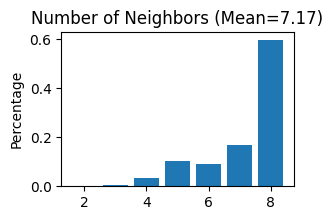

In [22]:
Cal_Spatial_Net(gdata, rad_cutoff=1.5
            )
Stats_Spatial_Net(gdata)


------Calculating spatial graph...
The graph contains 6468 edges, 902 cells.
7.1707 neighbors per cell on average.


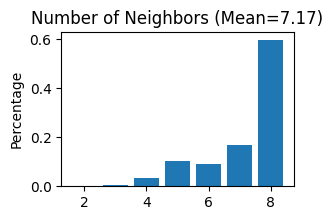

In [23]:
Cal_Spatial_Net(pdata, rad_cutoff=1.5)
Stats_Spatial_Net(pdata)

In [24]:
gdata = train_STAGATE(gdata,pdata,n_epochs=400,hidden_dims1=[512,30],hidden_dims2=[128, 30],a=0,alpha=0.35,pre_resolution1=0.25,pre_resolution2=0.2, save_loss=True)

Size of Input for gene data :  (902, 2000)
Size of Input for protein data :  (902, 199)
n_layers gene =  2
Hidden dim gene =  [2000, 512, 30]
n_layers protein =  2
Hidden dim protein =  [199, 128, 30]
enc1 =  Tensor("Placeholder_12:0", dtype=float32)
enc1 =  Tensor("Elu:0", shape=(None, None), dtype=float32)
enc2 =  Tensor("Placeholder_13:0", dtype=float32)
enc2 =  Tensor("Elu_1:0", shape=(None, None), dtype=float32)
enc3 =  Tensor("concat:0", shape=(None, 60), dtype=float32)
LATENT =  Tensor("dense_4/BiasAdd:0", shape=(None, 30), dtype=float32)
Instructions for updating:
Colocations handled automatically by placer.
dec1 =  Tensor("add_5:0", shape=(None, 30), dtype=float32)
dec1 =  Tensor("Elu_2:0", shape=(None, 512), dtype=float32)
dec2 =  Tensor("add_5:0", shape=(None, 30), dtype=float32)
dec2 =  Tensor("Elu_3:0", shape=(None, 128), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
START TRAIN
------Pre-c

C:\Users\KARAN\AppData\Roaming\Python\Python39\site-packages\umap\distances.py:1053: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\KARAN\AppData\Roaming\Python\Python39\site-packages\umap\distances.py:1061: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\KARAN\AppData\Roaming\Python\Python39\site-packages\umap\distances.

------Pre-clustering Protein using louvain with resolution=0.20
------Pruning the graph...
6468 edges before pruning.
5308 edges after pruning.
------Pruning the graph...
6468 edges before pruning.
2368 edges after pruning.


C:\Users\KARAN\AppData\Local\Temp\ipykernel_24548\2736959394.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prune_G_df1['Cell1'] = prune_G_df1['Cell1'].map(cells_id_tran1)
C:\Users\KARAN\AppData\Local\Temp\ipykernel_24548\2736959394.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prune_G_df2['Cell1'] = prune_G_df2['Cell1'].map(cells_id_tran2)
C:\Users\KARAN\AppData\Local\Temp\ipykernel_24548\2736959394.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Epoch: 0, Contrastive Loss: 8.7460, Loss: 1073.0756
Epoch: 1, Contrastive Loss: 8.4424, Loss: 1069.8984
Epoch: 2, Contrastive Loss: 8.1825, Loss: 1066.7086
Epoch: 3, Contrastive Loss: 7.9780, Loss: 1063.5125
Epoch: 4, Contrastive Loss: 7.8279, Loss: 1062.3970
Epoch: 5, Contrastive Loss: 7.7237, Loss: 1060.8157
Epoch: 6, Contrastive Loss: 7.6549, Loss: 1059.3418
Epoch: 7, Contrastive Loss: 7.6112, Loss: 1060.0695
Epoch: 8, Contrastive Loss: 7.5844, Loss: 1059.2566
Epoch: 9, Contrastive Loss: 7.5681, Loss: 1058.2690
Epoch: 10, Contrastive Loss: 7.5579, Loss: 1057.0654
Epoch: 11, Contrastive Loss: 7.5511, Loss: 1056.9473
Epoch: 12, Contrastive Loss: 7.5465, Loss: 1056.9396
Epoch: 13, Contrastive Loss: 7.5433, Loss: 1055.8955
Epoch: 14, Contrastive Loss: 7.5411, Loss: 1055.2808
Epoch: 15, Contrastive Loss: 7.5397, Loss: 1055.4700
Epoch: 16, Contrastive Loss: 7.5389, Loss: 1053.7548
Epoch: 17, Contrastive Loss: 7.5388, Loss: 1051.9613
Epoch: 18, Contrastive Loss: 7.5390, Loss: 1052.0850
Epo

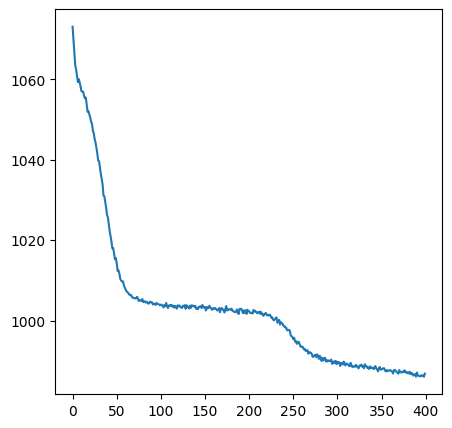

In [25]:
import matplotlib.pyplot as plt

plt.plot(gdata.uns['arch_loss'])
plt.show()

## Clustering code

In [26]:
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.3.0\bin\x64" + ";" + os.environ["PATH"]
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, packages
pandas2ri.activate()
stats = packages.importr('stats')
  

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='emb_pca', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def clustering(adata, n_clusters=8, key='emb', add_key='SpatialGlue', method='mclust', start=0.1, end=3.0, increment=0.01, use_pca=False):
    """\
    Spatial clustering based the latent representation.

    Parameters
    ----------
    adata : anndata
        AnnData object of scanpy package.
    n_clusters : int, optional
        The number of clusters. The default is 7.
    key : string, optional
        The key of the input representation in adata.obsm. The default is 'emb'.
    method : string, optional
        The tool for clustering. Supported tools include 'mclust', 'leiden', and 'louvain'. The default is 'mclust'. 
    start : float
        The start value for searching. The default is 0.1. Only works if the clustering method is 'leiden' or 'louvain'.
    end : float 
        The end value for searching. The default is 3.0. Only works if the clustering method is 'leiden' or 'louvain'.
    increment : float
        The step size to increase. The default is 0.01. Only works if the clustering method is 'leiden' or 'louvain'.  
    use_pca : bool, optional
        Whether use pca for dimension reduction. The default is false.

    Returns
    -------
    None.

    """
    
    if use_pca:
       pca = PCA(n_components=20, random_state=42) 
       adata.obsm[key + '_pca'] = pca.fit_transform(adata.obsm[key].copy())
    
    if method == 'mclust':
       if use_pca: 
          adata = mclust_R(adata, used_obsm=key + '_pca', num_cluster=n_clusters)
       else:
          adata = mclust_R(adata, used_obsm=key, num_cluster=n_clusters)
       adata.obs[add_key] = adata.obs['mclust']
    elif method == 'leiden':
       if use_pca: 
          res = search_res(adata, n_clusters, use_rep=key + '_pca', method=method, start=start, end=end, increment=increment)
       else:
          res = search_res(adata, n_clusters, use_rep=key, method=method, start=start, end=end, increment=increment) 
       sc.tl.leiden(adata, random_state=0, resolution=res)
       adata.obs[add_key] = adata.obs['leiden']
    elif method == 'louvain':
       if use_pca: 
          res = search_res(adata, n_clusters, use_rep=key + '_pca', method=method, start=start, end=end, increment=increment)
       else:
          res = search_res(adata, n_clusters, use_rep=key, method=method, start=start, end=end, increment=increment) 
       sc.tl.louvain(adata, random_state=0, resolution=res)
       adata.obs[add_key] = adata.obs['louvain']
       
def search_res(adata, n_clusters, method='leiden', use_rep='emb', start=0.1, end=3.0, increment=0.01):
    '''\
    Searching corresponding resolution according to given cluster number
    
    Parameters
    ----------
    adata : anndata
        AnnData object of spatial data.
    n_clusters : int
        Targetting number of clusters.
    method : string
        Tool for clustering. Supported tools include 'leiden' and 'louvain'. The default is 'leiden'.    
    use_rep : string
        The indicated representation for clustering.
    start : float
        The start value for searching.
    end : float 
        The end value for searching.
    increment : float
        The step size to increase.
        
    Returns
    -------
    res : float
        Resolution.
        
    '''
    print('Searching resolution...')
    label = 0
    sc.pp.neighbors(adata, n_neighbors=50, use_rep=use_rep)
    for res in sorted(list(np.arange(start, end, increment)), reverse=True):
        if method == 'leiden':
           sc.tl.leiden(adata, random_state=0, resolution=res)
           count_unique = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
           print('resolution={}, cluster number={}'.format(res, count_unique))
        elif method == 'louvain':
           sc.tl.louvain(adata, random_state=0, resolution=res)
           count_unique = len(pd.DataFrame(adata.obs['louvain']).louvain.unique()) 
           print('resolution={}, cluster number={}'.format(res, count_unique))
        if count_unique == n_clusters:
            label = 1
            break

    assert label==1, "Resolution is not found. Please try bigger range or smaller step!." 
       
    return res     

def plot_weight_value(alpha, label, modality1='mRNA', modality2='protein'):
  """\
  Plotting weight values
  
  """  
  import pandas as pd  
  
  df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
  df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
  df['label'] = label
  df = df.set_index('label').stack().reset_index()
  df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
  ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1, show=False)
  ax.set_title(modality1 + ' vs ' + modality2) 

  plt.tight_layout(w_pad=0.05)
  plt.show()    

## Clustering

In [27]:
for tool in ['mclust','leiden','louvain']:
   # we use mcluster as clustering tool by default.
   print(tool)

   # performing PCA
   gdata.obsm['emb_combined_pca'] = sc.tl.pca(gdata.obsm['MY_ARCH'])

   # clustering
   if tool == 'mclust':
      clustering(gdata, key='emb_combined_pca', add_key='1', n_clusters=6, method=tool)
   elif tool in ['leiden']:
      clustering(gdata, key='emb_combined_pca', add_key='2', n_clusters=6, method=tool, start=0.01, end=1.3, increment=0.05)
   elif tool in ['louvain']:
      clustering(gdata, key='emb_combined_pca', add_key='3', n_clusters=6, method=tool, start=0.01, end=1.3, increment=0.05)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



mclust
fitting ...
  |======================================================================| 100%
leiden
Searching resolution...
resolution=1.26, cluster number=10
resolution=1.2100000000000002, cluster number=7
resolution=1.1600000000000001, cluster number=7
resolution=1.11, cluster number=7
resolution=1.06, cluster number=7
resolution=1.01, cluster number=7
resolution=0.9600000000000001, cluster number=7
resolution=0.91, cluster number=6
louvain
Searching resolution...
resolution=1.26, cluster number=6


c:\Users\KARAN\anaconda3\envs\STAGATE_PT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\KARAN\anaconda3\envs\STAGATE_PT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


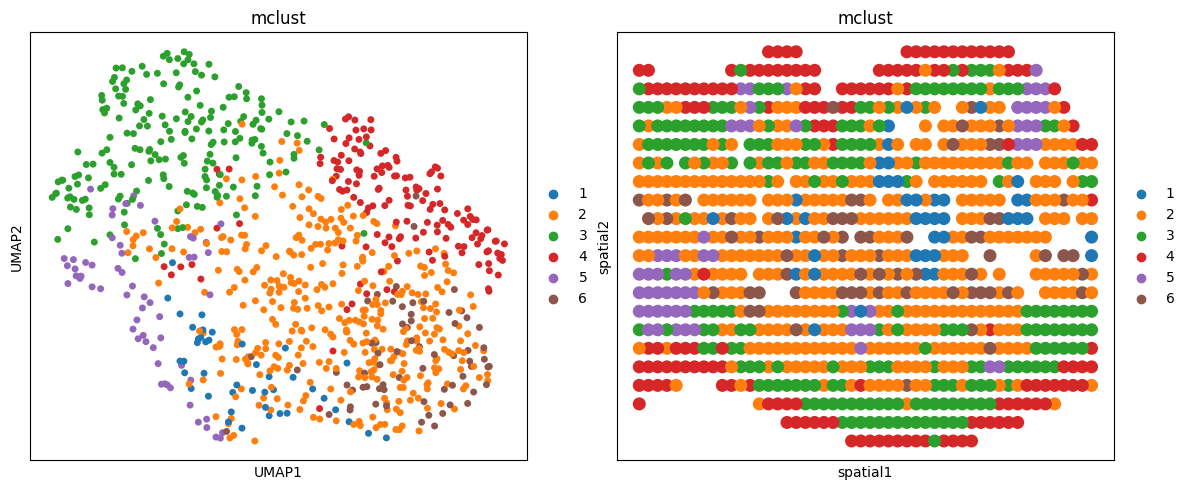

In [28]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='1', ax=ax_list[0], title='mclust', s=100, show=False)
sc.pl.embedding(gdata, basis='spatial', color='1', ax=ax_list[1], title='mclust', s=350, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

c:\Users\KARAN\anaconda3\envs\STAGATE_PT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\KARAN\anaconda3\envs\STAGATE_PT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


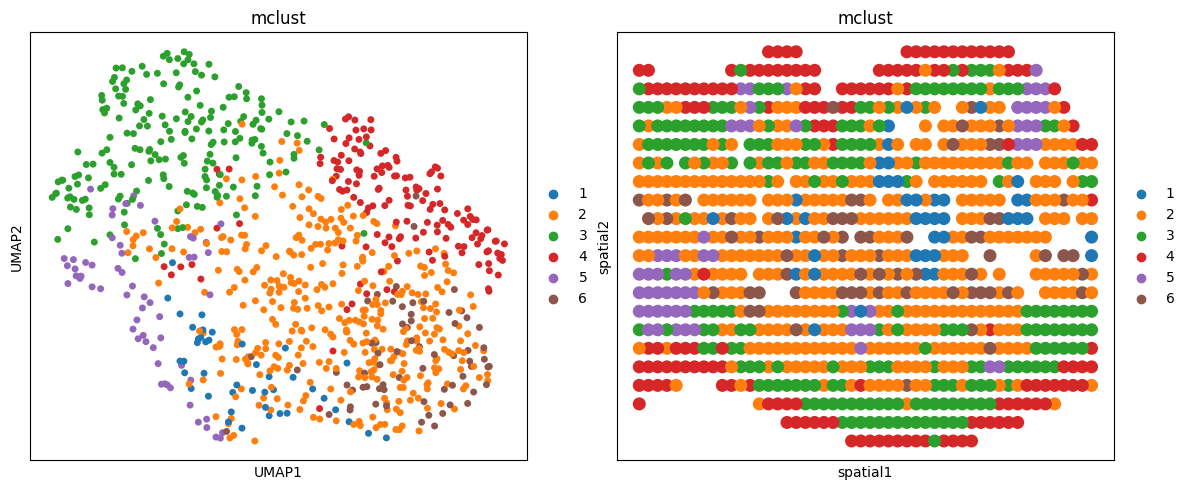

In [29]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='1', ax=ax_list[0], title='mclust', s=100, show=False)
sc.pl.embedding(gdata, basis='spatial', color='1', ax=ax_list[1], title='mclust', s=350, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

c:\Users\KARAN\anaconda3\envs\STAGATE_PT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\KARAN\anaconda3\envs\STAGATE_PT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


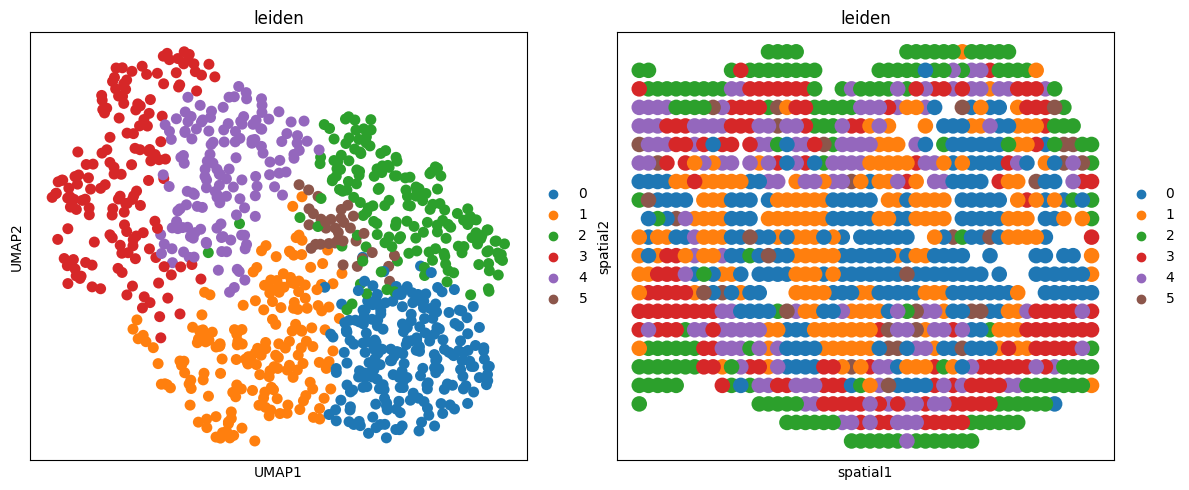

In [34]:
# visualization leiden
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='2', ax=ax_list[0], title='leiden', s=250, show=False)
sc.pl.embedding(gdata, basis='spatial', color='2', ax=ax_list[1], title='leiden', s=500, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()